In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Generate random positions and attractions for the flowers and bees

In [2]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction

## Define the distance functions

In [3]:
def dist(norms, alpha, c, b):
    # Gaussian distance function
    return c*np.exp(-alpha*(norms**2)) + b


def attraction_to_flower_gaussian(attraction_differences, distance, distance_norms, alpha=1, c=1, b=0):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    # find the unit vector of the distance
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    # return the net attraction
    return (velocity_unit_vector * dist(distance_norms, alpha, c, b)) / (1 + attraction_norm)


## Define constants used for the model

In [4]:
# number of flowers and bees
flower_qnty = 20
bee_qnty = 5
# max attraction value and max position value
max_attraction = 4
max_position = 100
# number of features for the flowers and bees to be attracted to
features = 5
# time steps and final time
t_steps = 2
t_final = 0.3
t_vals = np.linspace(0,t_final,t_steps)

# model parameters
nu = .2 * max_position # speed of the bees
xsi = 0.02 # nonlinearity of the bees
alpha = 0.5 / max_position # vision radius of the bees
c = 10 # attraction strength of the bees
b = 0.1 # constant attraction of the bees
eps = 0.6  # Proximity threshold for flower visitation
seconds_at_flower =  3 # seconds at flower before leaving

## Calculate and display the initial vector field of the bees

In [5]:
# grid size for uniform bee distribution
grid_size = 30

# create a grid of positions for the bees
x_positions = np.linspace(0, max_position, grid_size)
y_positions = np.linspace(0, max_position, grid_size)

# create a meshgrid of the positions
xx, yy = np.meshgrid(x_positions, y_positions)
bee_positions = np.vstack((xx.flatten(), yy.flatten()))

# no attraction difference for the bees
bee_preferences = np.zeros((features, bee_positions.shape[1])) 

# random initial conditions for the flowers
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# random initial conditions for the bees
near_corner = max_position - (0.1 * max_position)
beehive_position = np.array([near_corner, near_corner]).reshape(-1, 1)
bee_qnty = bee_positions.shape[1]

attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]
T_i = np.ones((bee_qnty, flower_qnty))

## Define the ODE function

In [6]:
def ode(t, x_flat, T_i):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))

    # get the distance from the flowers and the beehive
    distance_from_flowers = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_from_beehive = beehive_position[:, np.newaxis, :] - x[:, :, np.newaxis]

    # get the norm of the distance from the flowers and the beehive
    flower_norms = np.linalg.norm(distance_from_flowers, axis=0)

    # minus for the bees that are at the flowers
    T_i -= (flower_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))

    # gamma is 1 if T_i is greater than 0, 0 otherwise
    gamma = T_i > 0

    # get the attraction to the flowers
    attractors = attraction_to_flower_gaussian(attraction_differences, distance_from_flowers, flower_norms, alpha, c, b)

    # scale the attraction by gamma to turn off the attraction if the bee has visited the flower
    attractors = attractors * gamma

    # sum the attraction vectors
    combined_vector = attractors.sum(axis=2)

    # unit vector in direction of beehive
    beehive_direction = (distance_from_beehive / (np.linalg.norm(distance_from_beehive, axis=0))).squeeze()

    # scaling factor for beehive direction, function of time and distance from beehive
    beehive_scale = ((1 / (np.linalg.norm(distance_from_beehive, axis=0) + 1)) * (2*t)).squeeze()

    # attraction to the beehive
    beehive_attraction = (beehive_direction * beehive_scale).squeeze()

    # if the norm of the combined vector is greater than 1, set the beehive attraction to 0
    if np.any(np.linalg.norm(combined_vector, axis=0) > 3):
        beehive_attraction = np.zeros_like(beehive_attraction)

    # calculate the velocity of the bees
    velocity = (nu * (combined_vector + beehive_attraction)) / (xsi + np.linalg.norm(combined_vector + beehive_attraction, axis=0))

    # return the velocity for each bee
    return velocity.flatten()

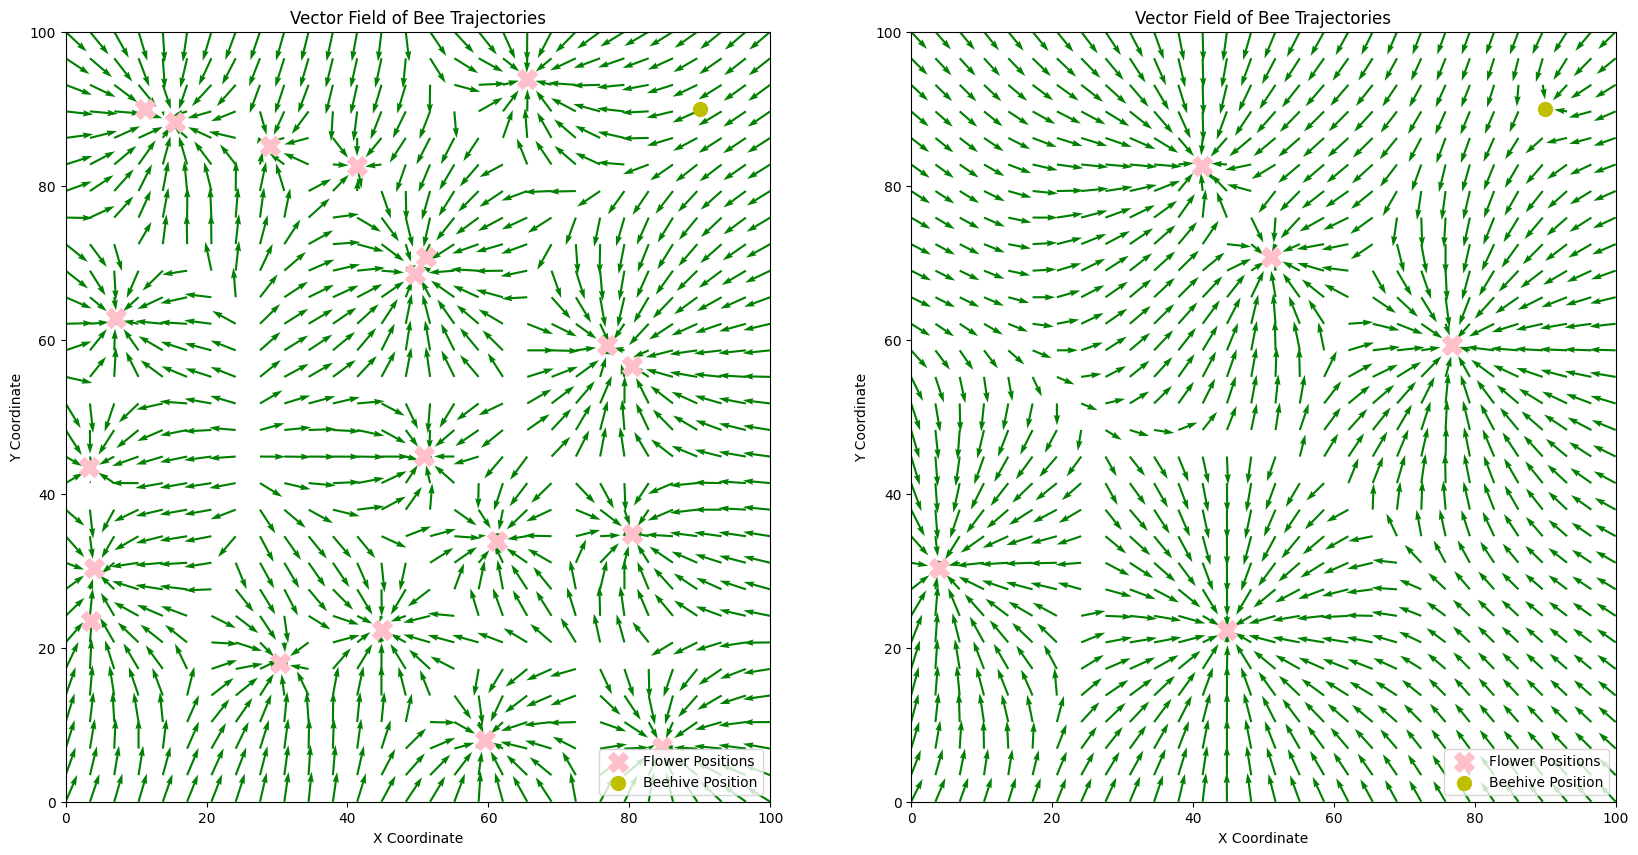

In [7]:
solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


arrow_color = 'green'
def plot_ax(ax, arrow_color, title, trajectories_reshaped, bee_positions, flower_positions, beehive_position, max_position, num_bees, num_time_points):
    for i in range(num_bees):
        start_x = bee_positions[0, i]
        start_y = bee_positions[1, i]
        end_x = trajectories_reshaped[0, i, -1]
        end_y = trajectories_reshaped[1, i, -1]

        ax.quiver(start_x, start_y, end_x - start_x, end_y - start_y,
                    color=arrow_color, angles='xy', scale_units='xy', scale=1.5, width=0.003)
        
    ax.scatter(flower_positions[0, :], flower_positions[1, :], marker='X', color='pink', s=200, label='Flower Positions')
    ax.scatter(beehive_position[0, :], beehive_position[1, :], marker='o', color='y', s=100, label='Beehive Position')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Vector Field of Bee Trajectories')
    ax.set_xlim(0, max_position)
    ax.set_ylim(0, max_position)
    ax.legend(loc='lower right')

plot_ax(ax1, arrow_color, 'Vector Field of Bee Trajectories', trajectories_reshaped, bee_positions, flower_positions, beehive_position, max_position, num_bees, num_time_points)

# remove a flower from the flower positions
flower_positions = flower_positions[:, :-15]
flower_attraction = flower_attraction[:, :-15]
flower_qnty -= 15

attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plot_ax(ax2, arrow_color, 'Vector Field of Bee Trajectories', trajectories_reshaped, bee_positions, flower_positions, beehive_position, max_position, num_bees, num_time_points)

plt.show()

## Define constants used for the model

In [8]:
# number of flowers and bees
flower_qnty = 15
bee_qnty = 5
# max attraction value and max position value
max_attraction = 4
max_position = 100
# number of features for the flowers and bees to be attracted to
features = 5
# time steps and final time
t_steps = 400
t_final = t_steps / 28
t_vals = np.linspace(0,t_final,t_steps)

# model parameters
nu = .4 * max_position # speed of the bees
xsi = 0.02 # nonlinearity of the bees
alpha = 0.5 / max_position # vision radius of the bees
c = 10 # attraction strength of the bees
b = 0.1 # constant attraction of the bees
eps = 0.6  # Proximity threshold for flower visitation
seconds_at_flower =  3 # seconds at flower before leaving

## Initial conditions of the bees and flowers

In [9]:
# random positions for the flowers and bees
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
# bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)

# have bees start at the bottom edge of the plot, evenly spaced
bee_positions = np.array([np.linspace(0, max_position, bee_qnty), np.zeros(bee_qnty)]).reshape(2, -1)

# random preferences for the bees and attraction for the flowers
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# location of the beehive
beehive_position = np.array([max_position/2, max_position - (0.02 * max_position)]).reshape(-1, 1)

## Calculate and display the trajectories of the bees

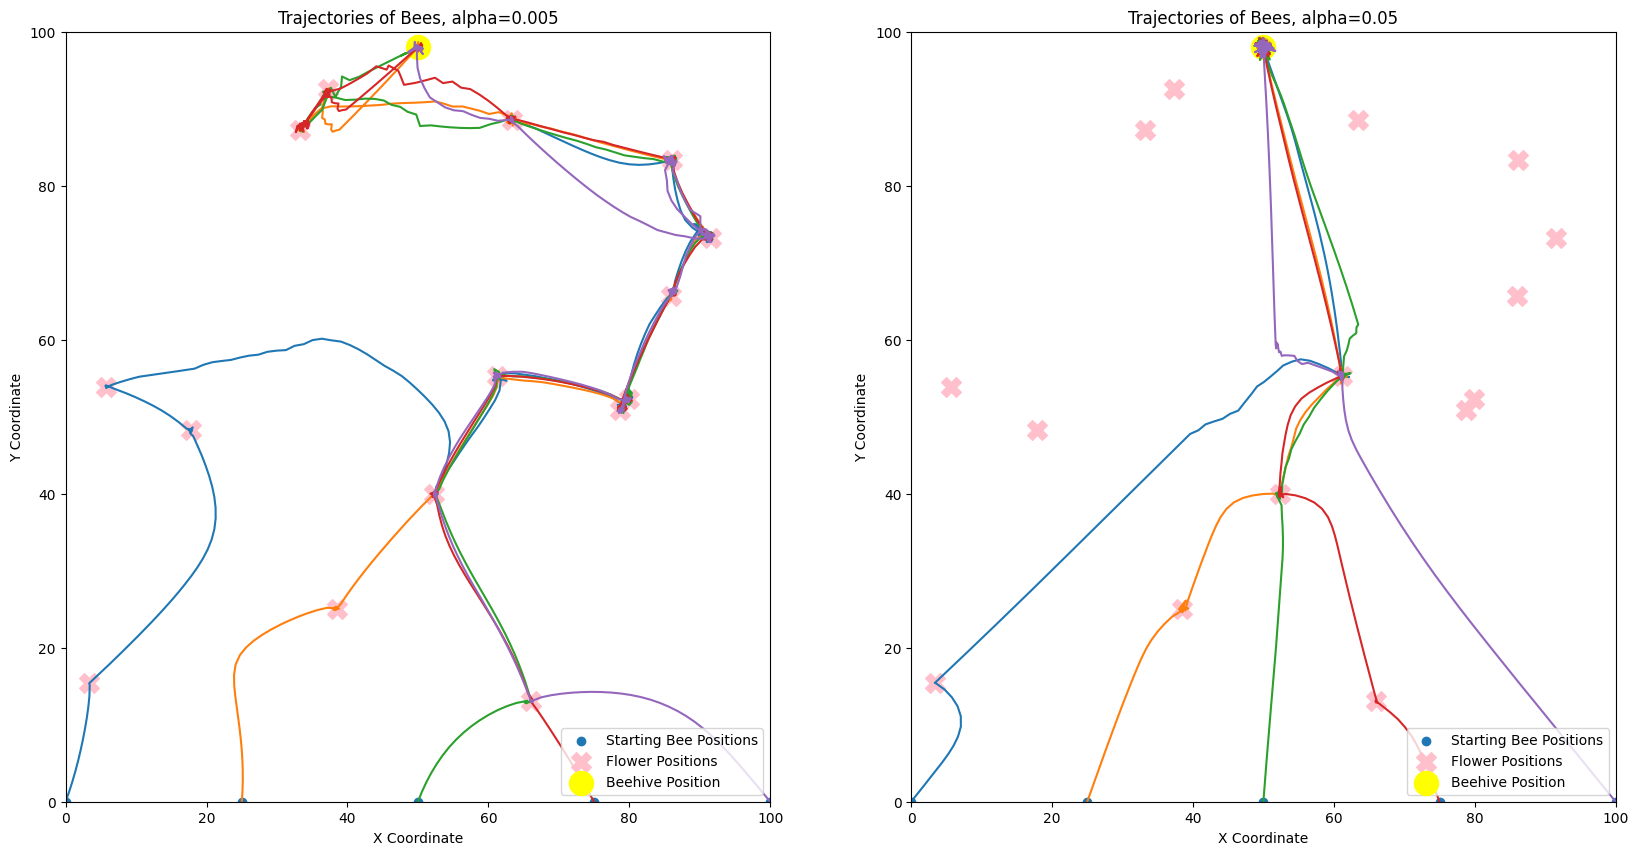

In [10]:
alpha = 0.5 / max_position  # Parameter for the ODE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

def plot_ax(ax, trajectories, bee_positions, flower_positions, beehive_position, max_position, alpha):

    num_time_points = trajectories.shape[1]
    trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

    for i in range(bee_qnty):
        # Extracting the x and y coordinates of the i-th bee
        x = trajectories_reshaped[0, i, :]
        y = trajectories_reshaped[1, i, :]
        ax.plot(x, y)

    ax.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Bee Positions')
    # plot the flowers
    ax.scatter(flower_positions[0, :], flower_positions[1, :], marker='X', color='pink', s=200, label='Flower Positions')

    # plot the beehive as large yellow dot
    ax.scatter(beehive_position[0, :], beehive_position[1, :], marker='o', color='yellow', s=300,label='Beehive Position')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'Trajectories of Bees, alpha={alpha}')
    ax.set_xlim(0,max_position)
    ax.set_ylim(0,max_position)
    # put the legend in the top left corner
    ax.legend(loc='lower right')

attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y
num_bees = bee_qnty

plot_ax(ax1, trajectories, bee_positions, flower_positions, beehive_position, max_position, alpha)

alpha = 5 / max_position  # Parameter for the ODE

attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

plot_ax(ax2, trajectories, bee_positions, flower_positions, beehive_position, max_position, alpha)



## Animate the trajectory

In [11]:
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))
alpha = 0.5 / max_position  # Parameter for the ODE
solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y
trajectories_reshaped = trajectories.reshape((2, bee_qnty, t_steps))




fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, max_position + 5)
ax.set_ylim(-5, max_position + 5)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Trajectories of Bees (Animation)')

bees = [ax.plot([], [], marker='o', color='yellow')[0] for _ in range(bee_qnty)]
bee_centers = [ax.plot([], [], marker='o', color='k')[0] for _ in range(bee_qnty)]
# set the bee size
for bee in bees:
    bee.set_markersize(11)
# set the bee center size
for bee_center in bee_centers:
    bee_center.set_markersize(4)
ax.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Bee Positions')
ax.scatter(flower_positions[0, :], flower_positions[1, :], marker='X', color='pink', label='Flower Positions')
ax.scatter(beehive_position[0, :], beehive_position[1, :], marker='h', color='yellow', s=200, label='Beehive Position')

def animate(frame):
    for i in range(bee_qnty):
        bees[i].set_data(trajectories_reshaped[0, i, frame], trajectories_reshaped[1, i, frame])
        bee_centers[i].set_data(trajectories_reshaped[0, i, frame], trajectories_reshaped[1, i, frame])
ani = FuncAnimation(fig, animate, frames=trajectories_reshaped.shape[2], interval=1000/30)
plt.close(fig)


In [12]:
ani.save('bee_flights.mp4', writer='ffmpeg')

ani.save('bee_flights.gif')
